In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.dpi'] = 150


default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = ['o', '*', 's', '^']

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

### Set save data

In [4]:
save_data = False

In [5]:
def prev_data(expt_path, filename=None):
    """Reopen saved data"""
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [9]:
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_240617


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Load config

In [10]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [ ]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

print(list(im))
# print(im)

In [ ]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print(f'set freq to [MHz] {lo_freq*1e-6}')
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

## Set TWPA parameters

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [ ]:
"""
TWPA ON
"""

print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN ON
lo_twpa.set_standby(False)
lo_twpa.set_output_state(True)
twpa_freq = float(yaml_cfg.hw.lo.twpa.frequency)
twpa_power = float(yaml_cfg.hw.lo.twpa.power)
lo_twpa.set_frequency(twpa_freq) # Set LO frequency
print(f'set twpa pump freq to {twpa_freq*1e-6} MHz')
lo_twpa.set_power(twpa_power) # Set LO power
print(f'set twpa pump power to {twpa_power} dBm')

In [ ]:
"""
TWPA OFF
"""
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN OFF
lo_twpa.set_standby(True)
lo_twpa.set_output_state(False)

# Qubit/resonator to probe

In [12]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [39]:
qubit_i = 0
results_Qi = all_results[qubit_i]

## Set reps and rounds

In [14]:
reps = 100
rounds = 10

# RFSoC Calibration

In [ ]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=0.8, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i]-15, # [MHz]
    reps=reps*rounds, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
tof.display(adc_trig_offset=145)

# Initial single tone resonator spectroscopy

In [ ]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 1.0 # MHz
npts = 150
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,
)
# rspec.cfg.device.readout.gain[qubit_i] = 0.35
rspec.cfg.device.readout.relax_delay = 25 # Wait time between experiments [us] - should be 5x resonator lifetime for good shape

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.data = rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]

res_freq_g = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
# res_freq_g = rspec.data['xpts'][np.argmax(rspec.data['amps'])]
yaml_cfg.device.readout.frequency[qubit_i] = res_freq_g

yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain[qubit_i]
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq[qubit_i])})
results_Qi.update({'Res freq (yaml)':yaml_cfg.device.readout.frequency[qubit_i]})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(f'qubit {qubit_i}', results_Qi)

In [ ]:
if save_data: saved_files.append(rspec.save_data())

# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [ ]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 250

qspec.cfg.expt = dict(
    start=np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i]/10), # Qubit pulse gain
    pulse_type='gauss',
    qTest=qubit_i,
    qZZ=None,
    checkEF=False,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
print(results_Qi)

In [ ]:
if save_data: saved_files.append(qspec.save_data())

## Pulse Probe (qubit) spectroscopy round 2

In [ ]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 15
npts = 250

qspec2.cfg.expt = dict(
    start=np.reshape(qspec2.cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i]/80), # Qubit pulse gain
    pulse_type='gauss',
    qTest=qubit_i,
    qZZ=None,
    checkEF=False,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
print(results_Qi)

In [ ]:
if save_data: saved_files.append(qspec2.save_data())

## Length Rabi

In [ ]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=reps*rounds,
    gain=np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i], # qubit gain [DAC units],
    # gain=32000, # qubit gain [DAC units],
    pulse_type='gauss',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
)
# lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

lengthrabi.display(fit=True)
# p = lengthrabi_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
# else: pi_len = (3/2 - p[2]/180)/2/p[1]
# pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

# lengthrabi_decay = p[3]

# print(f'Will use sigma {pi_len} for amplitude rabi')

In [ ]:
# if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude Rabi

In [ ]:
pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_len', pi_len)

In [ ]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i])))
# span = 32000
npts = 151

amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

# amprabi.display(fit=False)

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]})
print(f'*New pi_ge.gain\n', yaml_cfg.device.qubit.pulses.pi_ge.gain)
yaml_cfg.device.qubit.pulses.pi_ge.gain = yaml_cfg.device.qubit.pulses.pi_ge.gain.flatten().astype(int).tolist()
print(f'*New pi_ge.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.gain}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi.save_data())

## $T_1$

In [64]:
short_T1 = False
# short_T1 = True

In [ ]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 400
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    qTest=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit_log=False)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True, fit_log=False)
t1_qubit = t1_fit[3]
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(4*t1_qubit)
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_qubit, 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(f'qubit {qubit_i}', results_Qi)

In [ ]:
if save_data: saved_files.append(t1.save_data())

In [ ]:
# Sample data
data = np.random.randn(1000)

# Generate histogram
hist, bin_edges = np.histogram(data, bins=30)

# Plot the histogram
plt.figure()
for i in range(len(hist)):
    plt.plot([bin_edges[i], bin_edges[i+1]], [hist[i], hist[i]], color=default_colors[0])
    if i < len(hist) - 1:
        plt.plot([bin_edges[i+1], bin_edges[i+1]], [hist[i], hist[i+1]], color=default_colors[0])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.ylim(0, None)
plt.show()

print(hist)


plt.figure()
plt.hist(x=data, bins=30, linestyle='solid', histtype='step')

## $T_2$ Ramsey round 1

In [ ]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
# short_T1 = t1_qubit < 20
print('Short T1', short_T1)

In [ ]:
# ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
ramsey_freq = 3.0
print(f'Ramsey freq [MHz]: {ramsey_freq}')

In [ ]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(8), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=200,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=reps,
    rounds=rounds,
    qTest=qubit_i,
    checkEF=False,
    qZZ=None,
)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

# t2r.analyze(fit=True, fit_num_sin=2)
# t2r.display(fit=True, fit_num_sin=2)

t2r.analyze(fit=True)
t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = np.reshape(t2r.cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
results_Qi.update({'T2R':t2r_fit[3], 'T2R err':np.sqrt(t2r_fit_err[3][3])})
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

print(f'*New f_ge\n', yaml_cfg.device.qubit.f_ge)
yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
print(f'*New f_ge flattened\n{yaml_cfg.device.qubit.f_ge}')

data = t2r.data
fit_axis = 'avgq'
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data[fit_axis])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
ZZs = np.zeros((4,4))
reshaped_f_ge = np.reshape(t2r.cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZs[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]
for i in range(4):
    if (qubit_i+i)%4 == qubit_i: color = 'r'
    else: color = 'k'
    plt.axvline(t2r.cfg.expt.ramsey_freq - ZZs[qubit_i, (qubit_i+i)%4], color=color, linewidth=0.5, linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.xlim(-6, 6)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Ramsey on Q{qubit_i} (Ramsey Freq: {t2r.cfg.expt.ramsey_freq})')
plt.show()

In [ ]:
if save_data: saved_files.append(t2r.save_data())

## Amplitude Rabi round 2

In [ ]:
pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]
print('qubit', qubit_i, 'pi_len', pi_len)
# pi_len = 0.025

In [ ]:
amprabi_2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_2.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_2.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkEF=False, 
    n_pulses=n_pulses,
    qTest=qubit_i,
    qZZ=None,
)
amprabi_2.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # amprabi_2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_2.data = temp_data

amprabi_2.analyze(fit=True)

amprabi_2_fit, amprabi_2_fit_err = meas.fitting.get_best_fit(amprabi_2.data)

p = amprabi_2_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_2.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_2.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi_2.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]})
print(f'*New pi_ge.gain\n', yaml_cfg.device.qubit.pulses.pi_ge.gain)
yaml_cfg.device.qubit.pulses.pi_ge.gain = yaml_cfg.device.qubit.pulses.pi_ge.gain.flatten().tolist()
print(f'*New pi_ge.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.gain}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_2.save_data())

## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [ ]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(2) if t2r_fit[3] < 3 else soc.cycles2us(60), # [us]
    step=soc.cycles2us(150), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/15, # [MHz]
    reps=reps,
    rounds=rounds,
    checkEF=False,
    qTest=qubit_i,
    qZZ=None,
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# TESTING
# t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00004_ramsey_qubit2.h5')
# t2r_2.data = temp_data
# t2r_2.cfg = AttrDict(attrs['config'])

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
old_qubit_freq = np.reshape(t2r_2.cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i]
if abs(t2r_2_adjust[0]) <= ramsey_freq/10:
# if abs(t2r_2_adjust[0]) <= abs(t2r_2_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
    yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = old_qubit_freq + t2r_2_adjust[0]
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
    print(results_Qi)
    print(f'*New f_ge\n', yaml_cfg.device.qubit.f_ge)
    yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
    print(f'*New f_ge flattened\n{yaml_cfg.device.qubit.f_ge}')

else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [ ]:
if save_data: saved_files.append(t2r_2.save_data())

## $\pi$, -$\pi$ experiment

In [40]:
piminuspi = meas.PiMinusPiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PiMinusPiExpt{qubit_i}",
    config_file=config_path,
)

span_f = 1.5
npts_f = 75

piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))
piminuspi.cfg.expt = dict(
    start_N=0, # number gate repetitions
    step_N=20,
    expts_N=10,
    start_f=piminuspi.cfg.device.qubit.f_ge[qubit_i*4 + qubit_i]-span_f/2,
    step_f=span_f/npts_f,
    expts_f=npts_f+1,
    reps=reps*rounds,
    loops=1,
    pulse_type='gauss',

    checkEF=False,
    qTest=qubit_i,
    qZZ=None,

    test_pi_half=False,

    post_process='threshold',
    singleshot_reps=15000,
)

# print(piminuspi.cfg)
import Pyro4.util
try:
    piminuspi.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 76.44666666666666 	 angle (deg): -129.58813538417812 	 threshold ge: 256.647685083267


  0%|          | 0/10 [00:00<?, ?it/s]

Fit best freq 0.01875000037904579 which is -4110.589275171391 away from old freq 4110.60802517177


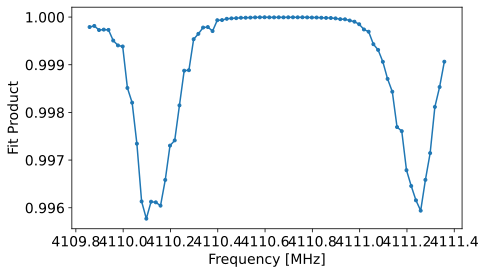

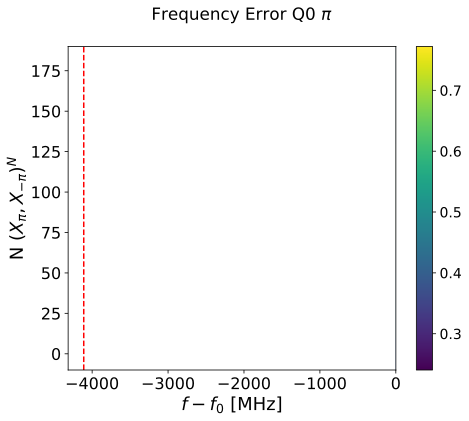

*Set qubit 0 freq to 0.01875000037904579*
{'Qubit freq': 0.01875000037904579}
*New f_ge
 [[1.87500004e-02 4.10504819e+03 4.11019858e+03 4.10987015e+03]
 [3.44280951e+03 3.44845274e+03 3.44708579e+03 3.44688742e+03]
 [4.76206071e+03 4.76110275e+03 4.76220157e+03 4.76167803e+03]
 [4.38114186e+03 4.38037033e+03 4.38114262e+03 4.38167954e+03]]
*New f_ge flattened
[0.01875000037904579, 4105.048189664584, 4110.198576889643, 4109.870151106654, 3442.8095108490056, 3448.4527389194704, 3447.0857887636976, 3446.8874200312653, 4762.060705219546, 4761.102749662887, 4762.201572322125, 4761.678033261405, 4381.14185795623, 4380.370331938204, 4381.142621732222, 4381.679544300405]


In [46]:
# # TESTING
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00000_PiMinusPiExpt0.h5')
# piminuspi.data =  temp_data
# piminuspi.cfg = AttrDict(attrs['config'])


data = piminuspi.data
piminuspi.analyze(fit=True)
piminuspi.display(fit=True)

yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = data["best_freq"]
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
print(results_Qi)
print(f'*New f_ge\n', yaml_cfg.device.qubit.f_ge)
yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
print(f'*New f_ge flattened\n{yaml_cfg.device.qubit.f_ge}')

In [ ]:
if save_data: pipiprog.save_data()

## GE error amplification

In [37]:
npulsecalib = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
    test_pi_half=False,
    error_amp=True,

    post_process='scale',
    singleshot_reps=15000,
)

# print(npulsecalib.cfg)
import Pyro4.util
try:
    npulsecalib.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 64.42666666666666 	 angle (deg): 74.91875264716298 	 threshold ge: 438.1979699907847


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 606RuntimeWarning: divide by zero encountered in divide
 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 607

fitparams [None, 0.017453292519943295]
From amps: adjust amplitude to 2637 / 1.0022130538393657 = 2631.177063497576


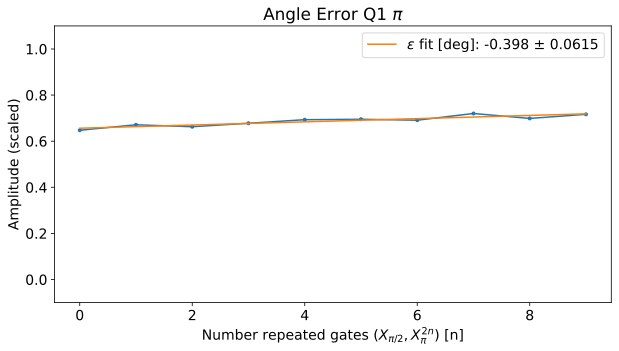

From avgi: adjust amplitude to 2637 / 1.0022150033775479 = 2631.1719452543525

From avgq: adjust amplitude to 2637 / 0.9999885078725541 = 2637.030305088345


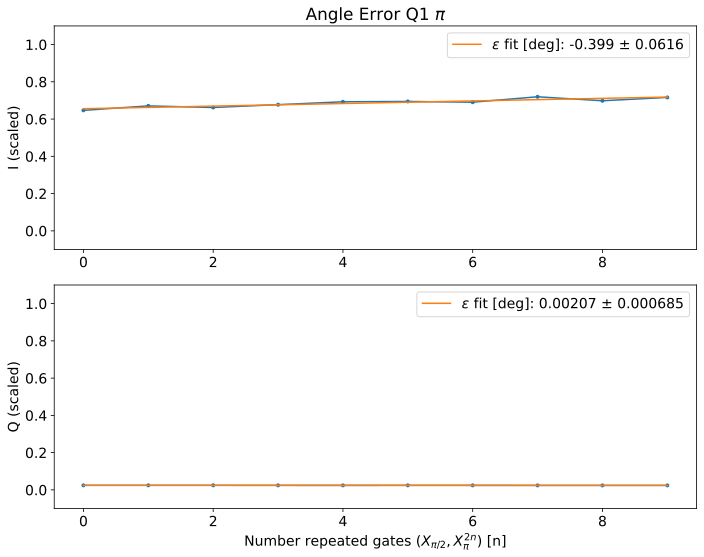

*Set pi pulse gain for qubit 1 to 2631*
*New pi_ge.gain
 [[ 1861  1914     0  1855]
 [ 2834  2631  2648  2631]
 [14489 14572 14389 14639]
 [  963   959   974   963]]
*New pi_ge.gain flattened
[1861, 1914, 0, 1855, 2834, 2631, 2648, 2631, 14489, 14572, 14389, 14639, 963, 959, 974, 963]
{'Qubit freq': 3448.4527389194704, 'Pi pulse gain': 2631}


In [38]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib.data
npulsecalib.analyze(fit=True, scale=None)
npulsecalib.display(fit=True, scale=None)

# npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)
fit_axis = 'avgi'
npulsecalib_fit = data['fit_avgi']
npulsecalib_fit_err = data['fit_err_avgi']

angle_err = npulsecalib_fit[1]
amp_ratio = (180 - angle_err) / 180
new_amp_ge = np.reshape(npulsecalib.cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ge.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i] = int(round(new_amp_ge))
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]})
print(f'*New pi_ge.gain\n', yaml_cfg.device.qubit.pulses.pi_ge.gain)
yaml_cfg.device.qubit.pulses.pi_ge.gain = yaml_cfg.device.qubit.pulses.pi_ge.gain.flatten().tolist()
print(f'*New pi_ge.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.gain}')
print(results_Qi)

In [ ]:
if save_data: npulsecalib.save_data()

## $T_2$ Echo

In [ ]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
# short_T1 = True
# short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

In [ ]:
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

In [ ]:
t2e = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    # step=soc.cycles2us(80), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    step=soc.cycles2us(30) if short_T1 else soc.cycles2us(150), # [us] 
    expts=201,
    ramsey_freq=max((ramsey_freq/15, 0.100)), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    echo_type='cpmg', # cp or cpmg
    reps=reps,
    # reps=10,
    rounds=rounds,
    qTest=qubit_i,
    qZZ=None,
    checkEF=False,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

print(f'Qubit {qubit_i}')
t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(results_Qi)
# print('Results updated.')

In [ ]:
if save_data: saved_files.append(t2e.save_data())

## (Divide len) Calibrate $\pi/2$ pulse

### Amplitude rabi for $\pi/2$ pulse (divide len) (use this for protocol)

In [50]:
divide_len = True

In [ ]:
pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_len', pi_len)

In [ ]:
amprabi_3 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_3.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_3.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkEF=False, 
    n_pulses=1,
    test_pi_half=True,
    qTest=qubit_i,
    qZZ=None,
)
amprabi_3.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # amprabi_3 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_3.data = temp_data

amprabi_3.analyze(fit=True)

amprabi_3_fit, amprabi_3_fit_err = meas.fitting.get_best_fit(amprabi_3.data)

p = amprabi_3_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_3.display(fit=False)
    print(f'WARNING: Fit pi/2 pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_3.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ge.half_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.half_gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.half_gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.half_gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.half_gain[qubit_i, qubit_i]})
print(f'*New pi_ge.half_gain\n', yaml_cfg.device.qubit.pulses.pi_ge.half_gain)
yaml_cfg.device.qubit.pulses.pi_ge.half_gain = yaml_cfg.device.qubit.pulses.pi_ge.half_gain.flatten().astype(int).tolist()
print(f'*New pi_ge.half_gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.half_gain}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_3.save_data())

### GE $\pi/2$ error amplification (divide len)

In [54]:
divide_len = True

In [ ]:
npulsecalib_gehalf = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalib_gehalf.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib_gehalf.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    test_pi_half=True,
    divide_len=divide_len,
    error_amp=True,

    checkEF=False,
    qTest=qubit_i,
    qZZ=None,

    post_process='scale',
    singleshot_reps=15000,
)

# print(npulsecalib_gehalf.cfg)
import Pyro4.util
try:
    npulsecalib_gehalf.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib_gehalf.data
npulsecalib_gehalf.analyze(fit=True, scale=None)
npulsecalib_gehalf.display(fit=True, scale=None)

# npulsecalib_gehalf_fit, npulsecalib_gehalf_fit_err = meas.fitting.get_best_fit(npulsecalib_gehalf.data)
fit_axis = 'avgi'
npulsecalib_gehalf_fit = data['fit_avgi']
npulsecalib_gehalf_fit_err = data['fit_err_avgi']

angle_err = npulsecalib_gehalf_fit[1]
amp_ratio = (90 - angle_err)/90
new_amp_half_ge = np.reshape(npulsecalib_gehalf.cfg.device.qubit.pulses.pi_ge.half_gain, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ge.half_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.half_gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.half_gain[qubit_i, qubit_i] = int(round(new_amp_half_ge))
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.half_gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.half_gain[qubit_i, qubit_i]})
print(f'*New pi_ge.half_gain\n', yaml_cfg.device.qubit.pulses.pi_ge.half_gain)
yaml_cfg.device.qubit.pulses.pi_ge.half_gain = yaml_cfg.device.qubit.pulses.pi_ge.half_gain.flatten().astype(int).tolist()
print(f'*New pi_ge.half_gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.half_gain}')
print(results_Qi)

In [ ]:
if save_data: npulsecalib_gehalf.save_data()

## (Divide gain) Calibrate $\pi/2$ pulse

### Amplitude rabi for $\pi/2$ pulse (divide gain) (use this for RB)

In [ ]:
divide_len = False

In [ ]:
pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_len', pi_len)

In [ ]:
amprabi_3 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_3.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*0.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_3.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkEF=False, 
    n_pulses=1,
    test_pi_half=True,
    divide_len=divide_len,
    qTest=qubit_i,
    qZZ=None,
)
amprabi_3.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # amprabi_3 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_3.data = temp_data

amprabi_3.analyze(fit=True)

amprabi_3_fit, amprabi_3_fit_err = meas.fitting.get_best_fit(amprabi_3.data)

p = amprabi_3_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_3.display(fit=False)
    print(f'WARNING: Fit pi/2 pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_3.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i]})
print(f'*New pi_ge.half_gain_pi_sigma\n', yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma)
yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma = yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma.flatten().astype(int).tolist()
print(f'*New pi_ge.half_gain_pi_sigma flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_3.save_data())

### GE $\pi/2$ error amplification (divide gain)

In [ ]:
divide_len = False

In [ ]:
npulsecalib_gehalf = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalib_gehalf.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib_gehalf.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
    test_pi_half=True,
    divide_len=divide_len,
    error_amp=True,

    post_process='scale',
    singleshot_reps=15000,
)

print(npulsecalib_gehalf.cfg)
import Pyro4.util
try:
    npulsecalib_gehalf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib_gehalf.data
npulsecalib_gehalf.analyze(fit=True, scale=None)
npulsecalib_gehalf.display(fit=True, scale=None)

# npulsecalib_gehalf_fit, npulsecalib_gehalf_fit_err = meas.fitting.get_best_fit(npulsecalib_gehalf.data)
fit_axis = 'avgi'
npulsecalib_gehalf_fit = data['fit_avgi']
npulsecalib_gehalf_fit_err = data['fit_err_avgi']

angle_err = npulsecalib_gehalf_fit[1]
amp_ratio = (90 - angle_err)/90
new_amp_half_ge = np.reshape(npulsecalib_gehalf.cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i] = int(round(new_amp_half_ge))
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i]})
print(f'*New pi_ge.half_gain_pi_sigma\n', yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma)
yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma = yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma.flatten().astype(int).tolist()
print(f'*New pi_ge.half_gain_pi_sigma flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma}')
print(results_Qi)

In [ ]:
if save_data: npulsecalib_gehalf.save_data()

# Resonator chi shift (g/e)

In [ ]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 3 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.data = rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = rspec_chi.data['xpts'][np.argmax(rspec_chi.data['amps'])]
print('Res freq e', res_freq_e)
res_freq_g = yaml_cfg.device.readout.frequency[qubit_i]
print('Res freq g', res_freq_g)
# res_freq_e = -83
# results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
chi_shift_eg = yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - res_freq_g)
print('Chi shift (e-g):', chi_shift_eg)
results_Qi.update({'Res chi shift (e - g)': chi_shift_eg})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(f'qubit {qubit_i}', results_Qi)

In [ ]:
if save_data: saved_files.append(rspec_chi.save_data())

# Qubit ef spectroscopy

## Pulse Probe EF spectroscopy

In [ ]:
qEFspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 250

qEFspec.cfg.expt = dict(
    start=np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))[qubit_i,qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i]/50), # ef pulse gain
    # gain=5000,
    pulse_type='gauss',
    qTest=qubit_i,
    qZZ=None,
    checkEF=True,
)
# qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

qEFspec_fit, qEFspec_fit_err = meas.fitting.get_best_fit(qEFspec.data)
yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = qEFspec_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
print(results_Qi)

In [ ]:
if save_data: saved_files.append(qEFspec.save_data())

## Pulse Probe EF spectroscopy round 2

In [ ]:
qEFspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 15
npts = 250

qEFspec2.cfg.expt = dict(
    start=np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))[qubit_i,qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i]/80), # ef pulse gain
    pulse_type='gauss',
    qTest=qubit_i,
    qZZ=None,
    checkEF=True,
)
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)
yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = qEFspec2_fit[2]
qubit_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
print(results_Qi)

In [ ]:
if save_data: saved_files.append(qEFspec2.save_data())

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [ ]:
pi_lenEF = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]
# pi_lenEF = 0.025
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

In [ ]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i])))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps*rounds,
    rounds=1,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkEF=True,
    qTest=qubit_i,
    qZZ=None,

    readout_cool=True,
    n_init_readout=1,
    n_trig=2,
    init_read_wait_us=5,
    singleshot_reps=20000,
    use_gf_readout=True,
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True, post_select=False)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)


In [ ]:
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]})
print(f'*New pi_ef.gain\n', yaml_cfg.device.qubit.pulses.pi_ef.gain)
yaml_cfg.device.qubit.pulses.pi_ef.gain = yaml_cfg.device.qubit.pulses.pi_ef.gain.flatten().astype(int).tolist()
print(f'*New pi_ef.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.gain}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabiEF.save_data())

## Length EF Rabi

In [ ]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(0), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    expts=121,
    reps=reps*rounds,
    gain=np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i], # qubit gain [DAC units],
    pulse_type='gauss',
    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True, fit_func='sin')

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=False, fit_func='sin')
# p = lengthrabiEF_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
# else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
# pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

# lengthrabiEF_decay = p[3]

# print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [ ]:
if save_data: saved_files.append(lengthrabiEF.save_data())

## Qubit temperature

In [ ]:
amprabiEF2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF2.cfg = AttrDict(deepcopy(yaml_cfg))

reps_temp=500
rounds_temp=reps*rounds*100//500

# reps_temp = 10
# rounds_temp = 10
print('reps', reps_temp, 'rounds', rounds_temp)

amprabiEF2.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=np.reshape(amprabiEF2.cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i], # [dac level]
    expts=2,
    reps=reps_temp*rounds_temp,
    rounds=1,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss',
    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,

    readout_cool=True,
    n_init_readout=1,
    n_trig=2,
    init_read_wait_us=5,
    singleshot_reps=20000,
    
    use_gf_readout=True,
)

# print(amprabiEF2.cfg)
amprabiEF2.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# post_select = False
post_select = True
# ps_threshold = None
ps_threshold = 450

In [ ]:
# TESTING
# amprabiEF_test = meas.AmplitudeRabiExperiment(config_file=config_path,)
# amprabiEF2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00004_amp_rabi_EF_qubit1.h5')
# amprabiEF2.data = temp_data

# amprabiEF2.analyze(fit=False)
# amprabiEF2.display(fit=False)

# fitparams = [None]*4
# fitparams[1] = 2/amprabiEF2.data['xpts'][-1]

# amprabiEF2_fit, amprabiEF2_fit_err = meas.fitting.get_best_fit(amprabiEF2.data)

# NATURAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(np.reshape(amprabiEF2.cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

fit_axis = 'amps'
# fit_axis = 'avgi' if post_select else 'amps'

amprabiEF.analyze(fit=False, post_select=post_select, ps_threshold=ps_threshold)
amprabiEF_data = amprabiEF.data[fit_axis]
# amprabiEF2_data = (amprabiEF2.data[fit_axis] + temp_data[fit_axis])/2
# p = amprabiEF.data[f'fit_{fit_axis}']
# efamp_normal = p[0]
efamp_normal = (max(amprabiEF.data[fit_axis]) - min(amprabiEF.data[fit_axis]))

amprabiEF2.analyze(fit=False, post_select=post_select, ps_threshold=ps_threshold)
amprabiEF2_data = amprabiEF2.data[fit_axis]
# p = amprabiEF2.data[f'fit_{fit_axis}']
# efamp_nopulse = p[0]
# fit_vals = meas.fitting.sinfunc(amprabiEF.data['xpts'], *p)
# std_dev_no_pulse = np.std(fit_vals[:10])
# efamp_nopulse = (max(fit_vals) - min(fit_vals))-2*std_dev_no_pulse
efamp_nopulse = (max(amprabiEF2.data[fit_axis]) - min(amprabiEF2.data[fit_axis]))

# amprabiEF2.display(fit=True, fit_func='sin')

print('yscale normal:', efamp_normal)
print('yscale no pulse:', efamp_nopulse)

temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))

print(f'qubit {qubit_i}')
print('Qubit temp [mK]:', temp)
results_Qi.update({'Qubit temp [mK]':temp})
print('Qubit E thermal population (%):', efamp_nopulse/efamp_normal*100)

amprabiEF2.display(fit=False)
results_Qi.update({'Qubit E thermal population (%)':efamp_nopulse/efamp_normal*100})
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabiEF2.save_data())

## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [20]:
qubitEF_hwhm = 2
# short_T1 = False

In [ ]:
ramseyEF_freq = max((min((np.abs(np.ceil(qubitEF_hwhm)), 3)), 2))

t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    checkEF=True,
    reps=reps,
    rounds=rounds,
    qTest=qubit_i,
    qZZ=None,
)

import Pyro4.util
try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = np.reshape(t2EFr.cfg.device.qubit.f_ef, (4,4))[qubit_i, qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(f'*New f_ef\n', yaml_cfg.device.qubit.f_ef)
yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
print(f'*New f_ef flattened\n{yaml_cfg.device.qubit.f_ef}')
results_Qi.update({'T2R EF':t2EFr_fit[3], 'T2R EF err':np.sqrt(t2EFr_fit_err[3][3])})
print(all_results)

In [ ]:
if save_data: saved_files.append(t2EFr.save_data())

## Amplitude EF Rabi round 2

In [ ]:
pi_lenEF = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]
# pi_lenEF = 0.030
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

In [ ]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i])))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    rounds=rounds,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]})
print(f'*New pi_ef.gain\n', yaml_cfg.device.qubit.pulses.pi_ef.gain)
yaml_cfg.device.qubit.pulses.pi_ef.gain = yaml_cfg.device.qubit.pulses.pi_ef.gain.flatten().astype(int).tolist()
print(f'*New pi_ef.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.gain}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabiEF.save_data())

## EF Ramsey Fringe Round 2
Update the T2 EF but not the frequency

In [ ]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubitEF_hwhm = 7
# short_T1 = False

In [ ]:
t2EFr_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr_2.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(80), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq/10, # [MHz]
    checkEF=True,
    reps=reps,
    rounds=rounds,
    qTest=qubit_i,
    qZZ=None,
)

import Pyro4.util
try:
    t2EFr_2.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# # t2EFr_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr_2.data = temp_data

t2EFr_2.analyze(fit=True)
t2EFr_2_fit, t2EFr_2_fit_err, t2EFr_2_adjust = meas.fitting.get_best_fit(t2EFr_2.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = np.reshape(t2EFr_2.cfg.device.qubit.f_ef, (4,4))[qubit_i, qubit_i]

if not isinstance(t2EFr_2_fit, (list, np.ndarray)):
    t2EFr_2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr_2.display(fit=True)

if t2EFr_2_adjust[0] > ramseyEF_freq/10:
    print('WARNING: your EF frequency is not converging!')
else:
    # yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
    # yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = old_qubit_freq + t2EFr_2_adjust[0]
    # print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
    # print(f'*New f_ef\n', yaml_cfg.device.qubit.f_ef)
    # yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
    # print(f'*New f_ef flattened\n{yaml_cfg.device.qubit.f_ef}')
    results_Qi.update({'T2R EF':t2EFr_2_fit[3], 'T2R EF err':np.sqrt(t2EFr_2_fit_err[3][3])})
    # results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)

In [ ]:
if save_data: saved_files.append(t2EFr.save_data())

## EF error amplification

In [ ]:
npulsecalibEF = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEFQ{qubit_i}",
    config_file=config_path,
)

npulsecalibEF.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalibEF.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=10,
    pulse_type='gauss',
    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,
    test_pi_half=False,
    error_amp=True,

    post_process='scale',
    singleshot_reps=15000,
    # singleshot_reps=1000,
)

print(npulsecalibEF.cfg)
import Pyro4.util
try:
    npulsecalibEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalibEF.data
npulsecalibEF.analyze(fit=True)
npulsecalibEF.display(fit=True)

# npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalibEF.data)
fit_axis = 'avgi'
npulsecalibEF_fit = data[f'fit_{fit_axis}']
npulsecalibEF_fit_err = data[f'fit_err_{fit_axis}']

angle_err = npulsecalibEF_fit[1]
amp_ratio = (180 - angle_err) / 180
new_amp_ef = np.reshape(npulsecalibEF.cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ef.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i] = int(round(new_amp_ef))
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]})
print(f'*New pi_ef.gain\n', yaml_cfg.device.qubit.pulses.pi_ef.gain)
yaml_cfg.device.qubit.pulses.pi_ef.gain = yaml_cfg.device.qubit.pulses.pi_ef.gain.flatten().tolist()
print(f'*New pi_ef.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.gain}')
print(results_Qi)

In [ ]:
if save_data: npulsecalibEF.save_data()

## (Divide len) Calibrate EF $\pi/2$ pulse
this is mostly only for RB

### Amplitude rabi for EF $\pi/2$ pulse (divide len)

In [ ]:
pi_lenEF = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

In [ ]:
divide_len = True

In [ ]:
amprabi_4 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_4.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_4.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    n_pulses=n_pulses,
    test_pi_half=True,
    divide_len=divide_len,
    qTest=qubit_i,
    qZZ=None,
    checkEF=True, 
)
amprabi_4.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # amprabi_4 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_4.data = temp_data

amprabi_4.analyze(fit=True)

amprabi_4_fit, amprabi_4_fit_err = meas.fitting.get_best_fit(amprabi_4.data)

p = amprabi_4_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_4.display(fit=False)
    print(f'WARNING: Fit pi/2 pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_4.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.half_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi/2 EF pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i]})
print(f'*New pi_ef.half_gain\n', yaml_cfg.device.qubit.pulses.pi_ef.half_gain)
yaml_cfg.device.qubit.pulses.pi_ef.half_gain = yaml_cfg.device.qubit.pulses.pi_ef.half_gain.flatten().astype(int).tolist()
print(f'*New pi_ef.half_gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_4.save_data())

### EF $\pi/2$ error amplification (divide len)

this is mostly only necessary for RB

In [ ]:
divide_len = True

In [ ]:
npulsecalib_efhalf = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEF_half_Q{qubit_i}",
    config_file=config_path,
)

npulsecalib_efhalf.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib_efhalf.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    test_pi_half=True,
    divide_len=divide_len,
    error_amp=True,

    checkEF=True,
    qTest=qubit_i,
    qZZ=None,

    post_process='scale',
    singleshot_reps=15000,
)

print(npulsecalib_efhalf.cfg)
import Pyro4.util
try:
    npulsecalib_efhalf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib_efhalf.data
npulsecalib_efhalf.analyze(fit=True, scale=None)
npulsecalib_efhalf.display(fit=True, scale=None)

# npulsecalib_efhalf_fit, npulsecalib_efhalf_fit_err = meas.fitting.get_best_fit(npulsecalib_efhalf.data)
fit_axis = 'avgi'
npulsecalib_efhalf_fit = data[f'fit_{fit_axis}']
npulsecalib_efhalf_fit_err = data[f'fit_err_{fit_axis}']

angle_err = npulsecalib_efhalf_fit[1]
amp_ratio = (90 - angle_err)/90
new_amp_half_ef = np.reshape(npulsecalib_efhalf.cfg.device.qubit.pulses.pi_ef.half_gain, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ef.half_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i] = int(round(new_amp_half_ef))
print(f'*Set pi/2 EF pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i]})
print(f'*New pi_ef.half_gain\n', yaml_cfg.device.qubit.pulses.pi_ef.half_gain)
yaml_cfg.device.qubit.pulses.pi_ef.half_gain = yaml_cfg.device.qubit.pulses.pi_ef.half_gain.flatten().astype(int).tolist()
print(f'*New pi_ef.half_gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain}')
print(results_Qi)

In [ ]:
if save_data: npulsecalib_efhalf.save_data()

## (Divide gain) Calibrate EF $\pi/2$ pulse

### Amplitude rabi for EF $\pi/2$ pulse (divide gain) (use this for RB)

In [ ]:
pi_lenEF = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

In [ ]:
divide_len = False

In [ ]:
amprabi_4 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_4.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*0.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_4.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkEF=True, 
    n_pulses=n_pulses,
    test_pi_half=True,
    divide_len=divide_len,
    qTest=qubit_i,
    qZZ=None,
)
amprabi_4.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # amprabi_4 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_4.data = temp_data

amprabi_4.analyze(fit=True)

amprabi_4_fit, amprabi_4_fit_err = meas.fitting.get_best_fit(amprabi_4.data)

p = amprabi_4_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_4.display(fit=False)
    print(f'WARNING: Fit pi/2 pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_4.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set EF pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i]})
print(f'*New pi_ef.half_gain_pi_sigma\n', yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma)
yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma = yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma.flatten().astype(int).tolist()
print(f'*New pi_ef.half_gain_pi_sigma flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_4.save_data())

### EF $\pi/2$ error amplification (divide gain)

this is mostly only necessary for RB

In [ ]:
divide_len = False

In [ ]:
npulsecalib_efhalf = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEF_half_Q{qubit_i}",
    config_file=config_path,
)

npulsecalib_efhalf.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib_efhalf.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    test_pi_half=True,
    divide_len=divide_len,
    error_amp=True,

    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,

    post_process='scale',
    singleshot_reps=15000,
)

print(npulsecalib_efhalf.cfg)
import Pyro4.util
try:
    npulsecalib_efhalf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib_efhalf.data
npulsecalib_efhalf.analyze(fit=True, scale=None)
npulsecalib_efhalf.display(fit=True, scale=None)

# npulsecalib_efhalf_fit, npulsecalib_efhalf_fit_err = meas.fitting.get_best_fit(npulsecalib_efhalf.data)
fit_axis = 'avgi'
npulsecalib_efhalf_fit = data[f'fit_{fit_axis}']
npulsecalib_efhalf_fit_err = data[f'fit_err_{fit_axis}']

angle_err = npulsecalib_efhalf_fit[1]
amp_ratio = (90 - angle_err)/90
new_amp_half_ef = np.reshape(npulsecalib_efhalf.cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i] = int(round(new_amp_half_ef))
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i]})
print(f'*New pi_ef.half_gain_pi_sigma\n', yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma)
yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma = yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma.flatten().astype(int).tolist()
print(f'*New pi_ef.half_gain_pi_sigma flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma}')
print(results_Qi)

In [ ]:
if save_data: npulsecalib_efhalf.save_data()

# Resonator chi shift (e/f)

In [ ]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.data = rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
print('ef chi shift', yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i]))
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
results_Qi.update({'Res freq ef (yaml)':res_freq_f})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [ ]:
if save_data: saved_files.append(rspecEF_chi.save_data())

# Single Shot

In [46]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Single shot optimization

In [ ]:
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
qubit_i = 3

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

span_f = 1.0*abs(results_Qi['Res kappa']) # MHz
npts_f = 15
# span_f = 0
# npts_f = 1

span_gain = 0.4
npts_gain = 8
# span_gain = 0.0
# npts_gain = 8

# span_len = 5 # us
# npts_len = 10
span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qTest=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2,
    start_gain=0.2,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,
    # start_gain=0.2,
    # step_gain=0,
    # expts_gain=1,

    start_len=shotopt.cfg.device.readout.readout_length[qubit_i],
    step_len=span_len/npts_len,
    expts_len=npts_len,
    # start_len=7,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [ ]:

# Using readlines()
file1 = open('C:\\Users\\slab\\Downloads\\singleshot_opt.txt', 'r')
lines = file1.readlines()
freqs = []
gains = []
lengths = []
fids = []

line = lines[0]
words = line.split()
freq = float(words[1][:-1])
freqs.append(freq)
gain = float(words[3][:-1])
gains.append(gain)
length = float(words[5])
lengths.append(length)

fid_line = lines[1]
fids.append(float(fid_line.split()[3]))
 
# Strips the newline character
for i in range(2, len(lines), 2):
    line = lines[i]
    words = line.split()
    freq = float(words[1][:-1])
    if freq not in freqs: freqs.append(freq)
    gain = float(words[3][:-1])
    if gain not in gains: gains.append(gain)
    length = float(words[5])
    if length not in lengths: lengths.append(length)

    fid_line = lines[i+1]
    fids.append(float(fid_line.split()[3]))
    continue

fids = np.append(fids, [0]*22)
fids = np.reshape(fids, newshape=(len(freqs), len(gains), len(lengths)))

# lenpts = [data['lenpts'][0]]
for g_ind, gain in enumerate(gains):
    for l_ind, l in enumerate(lengths):
        plt.plot(freqs, fids[:,g_ind, l_ind], 'o-', label=f'gain: {gain:.2}, len [us]: {l}')
plt.xlabel('Frequency [MHz]')
plt.ylabel(f'Fidelity [%]')
plt.legend()
plt.show()


In [ ]:
if save_data: saved_files.append(shotopt.save_data())

next qubit

In [ ]:
qubit_i = 2
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.6
npts_gain = 6

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qTest=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.1,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=5,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [ ]:
if save_data: saved_files.append(shotopt.save_data())

next qubit

In [ ]:
qubit_i = 3
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.1
npts_gain = 8

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qTest=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=8.0,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [ ]:
if save_data: saved_files.append(shotopt.save_data())

## Best readout parameters

In [49]:
qubit_i = 3

In [ ]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=20000,
    check_f=False,
    qTest=qubit_i,
)

# shot.cfg.device.readout.frequency=freq_opt
# shot.cfg.device.readout.gain[qubit_i]=gain_opt
# print(freq_opt, gain_opt)
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain[qubit_i] = 0.45
# shot.cfg.device.readout.readout_length = 2.0 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)
results_Qi.update({'Single shot g-e fidelity (%)': 100*shot.data['fids'][0]})

In [ ]:
if save_data: saved_files.append(shot.save_data())

In [ ]:
# TESTING
shot = meas.HistogramExperiment(config_file=config_path)
temp_data, attrs = prev_data('S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00000_single_shot_qubit2.h5')
shot.cfg = AttrDict(attrs['config'])
shot.data = temp_data

In [ ]:
# Checking for drift vs. shot number

data = shot.data

Ies = data['Ie']
Qes = data['Qe']
Igs = data['Ig']
Qgs = data['Qg']

plot_e = False

if plot_e:
    i, q = Ies, Qes
else:
    i, q = Igs, Qgs

amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

# plt.plot(amps, '.', label='amps')
# plt.ylabel('Amps [ADC units]')
# plt.xlabel('Shot number')
# plt.legend()
# plt.show()

plt.title(f'Q{shot.cfg.expt.qTest} {"e" if plot_e else "g"}')
plt.plot(phases, '.', label='phases')
plt.axhline(0, color='r')
# plt.axhline(1.5, color='r')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(i, '.', label='i')
plt.ylabel('I [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(q, '.', label='Q')
plt.ylabel('Q [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

# Results

In [ ]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)